In [7]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [8]:
import impl.layer as l

class GRU2:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth_train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D

        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        # concat: [h, x]: D+H=Z
        X = np.column_stack((h_old, X_one_hot))

        # gate: h_prob
        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        # signal: h_pred
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h_next and y_pred
        h = h_old + hz * (hh - h_old)
        y, y_cache = l.fc_forward(h, Wy, by)

        cache = h_old, X, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_old, X, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache = cache
        
        dh_next = dh.copy()

        # h_next and y_pred
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dh_old1 = (1. - hz) * dh

        # signal: h_pred
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX, dWh, dbh = l.fc_backward(dhh, hh_cache)
        dh_old2 = dX[:, :self.H]
        dX1 = dX[:, self.H:]

        # gate: h_prob
        dhz = (hh - h_old) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dX, dWz, dbz = l.fc_backward(dhz, hz_cache)
        dh_old3 = dX[:, :self.H]
        dX2 = dX[:, self.H:]

        # concat: [h, x]
        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX1 + dX2

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, 
                    bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer])
                caches[layer].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss # + reg_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y) #/ y_train.shape[0] # no reg_loss
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for layer in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer])
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [18]:
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = np.log(len(set(X_train)))
    #     smooth_loss = -np.log(1.0 / len(set(X_train)))
    eps = 1e-8

    for iter in range(1, n_iter + 1):

        #         if idx >= len(minibatches):
        #             idx = 0
        #             state = nn.initial_state()
        #         X_mini, y_mini = minibatches[idx]
        #         idx += 1
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            dX, grads = nn.train_backward(dys, caches)
            
            nn.losses['train'].append(loss)
            smooth_loss = 0.999 * smooth_loss + 0.001 * loss
            nn.losses['smooth_train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=(mb_size*10))
            print(sample)
            
    return nn

In [ ]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 130 # epochs
alpha = 1e-3 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-13 loss: 5.1242
Japar in pertenf irtarncod Jdpinas 2s instros piosecincinh ompterouterithild isolectopese, eliti, the
Iter-13 loss: 15.8386
a frar co une-pyocyurt anthires testOhecente eref tet anliintpipec thil ca.ensicites lrieseaseder, is
Iter-13 loss: 11.7716
N ureary The lotecedestiticnestrccec fectestonencemiccomeccurtitititheccoromemlucseatercitesumrichest
Iter-13 loss: 14.2275
Ned Japan as taon ar 18. Neceist in Aiind in the cistilates aile45 cemee eegin teiterite. Astevinc th
Iter-13 loss: 13.3558
mina, 19t, Japan is the casurectainsisa Csed petorid, isedhitediis is is liwe, on in thiss cid liurea
Iter-13 loss: 19.4487
uy 185y ficesel in 19th is aceded rohest Esar oluthed is licseced inlleco weledisodcstsicsticsepiitse
Iter-13 loss: 13.9488
usori, Japan is larliinn wlocitintinh cuctrarea tse pdecites he wecitc is isithecio ist nitetin iisit
Iter-13 loss: 14.6695
-oper ca the jth,sccurmedin metitere cised nteithe istitirt in tergest este countrecid ctithecita, me
Iter-13 l

Iter-13 loss: 11.5576
lapino om. Nitileciititilitint ind is divedsichisioan es as livicers sing astin is the oppicith und i
Iter-13 loss: 10.0297
19126 lyves in is ins liviges Eisse sap hint hrso as lapatesg hustresiis es ant Japan istandsinapin t
Iter-13 loss: 9.9124
nas Fant arwes fof urea andin perit lion sisn thint in the in papin is anlitith in sfaigsst restris t
Iter-13 loss: 11.1959
out apira al the cimbecmtomectort mefoterdic. ufmmpesteactroucombombencisins indesit inssich estnteri
Iter-13 loss: 10.2778
te hona s., whensurandins cust enuJapas is as isspestis onsit in thesitherced sed intiss cikt untin i
Iter-13 loss: 4.9743
. Japanasi"g al tionsem in isation iinsilicitonhin ih ofestitines is diventin pis chichitite hisithis
Iter-13 loss: 20.3983
 insth lore estecegestinttitedes. miessec an in Asion Apurthinuracount eppintrin rins es in sissisanw
Iter-13 loss: 17.3666
kan in o7,donnsin Japin is od tevesered unen, in in dhivithe if disinased. sh ssicatea inesea )h lees
Iter-13 lo

n oferoa desed in the "asad istisilitan. ind in peccoic cinsis Eimilisithicich cerind chd cides sitin
Iter-13 loss: 22.2822
rry Hhintd The an cinsed in waste si thens usd histhithes or tinnsist innriis thice pinitith in iis i
Iter-13 loss: 12.9853
rlamita.y ind of dopinsios of inilasithiserca pand cisudiisilgin.is cithisid imithis lasid io shinisi
Iter-13 loss: 17.0433
apntaves an leceses anastres crlitatencicintd ir dspesisiting empin cacslacisins. Sec ar es it icilis
Iter-13 loss: 15.0764
ra io whisi anded in thi. pinsisid Tipin iissoninhithis than Chinndin thiris divisons ih in thicicisi
Iter-13 loss: 15.9662
, hasko expered andinlias in thesins is in the hhishess is pectorin iis cinesid iodes thersedhicith h
Iter-13 loss: 17.0320
 toben Japan is thenrstoriting insilith is an iidircing is ligstucitipe hiont. Ashllopitith icicisr i
Iter-13 loss: 13.3130
solmoxparie "ampesto popto enso insty is in iiichicithisihins coand war in ianthiis iinthe epond Asip
Iter-13 loss: 17.9302
the Sas 

a Sy whis whithicheisess thesisediviasihe in Japan is inntstich. Japenose hatit histlrconedesedcicnti
Iter-13 loss: 15.2480
n esthintserlame forntredes, rencectmrulerbictticnteech cupeectorl cit
 icctounithestencith cist cetu
Iter-13 loss: 10.1295
0th Efol, the estin thise sila is tiseseccitithigOtiris. insid ipustihions milititeonTipencile is mit
Iter-13 loss: 19.4857
irs lasseasd ingts. Asit wistecinided iteth cint. iotThidintihitine ictise's sist Japisiting estliter
Iter-13 loss: 11.4840
rte tir ten126. onllevouliwesiiin iistionliom indilisgis langisi citas this thined atiladesitising th
Iter-13 loss: 14.4042
ed if 0h8k thRefhurith surtry iustoritis cinsilicisin in iigith in aedsicginstisste imperesis imithis
Iter-13 loss: 10.6526
n, whe curly in Covellititint. Japan istiritivitesndsi. licsed the Oceredsithicisetsiigitest ncowentr
Iter-13 loss: 11.8917
e ntry in lirisess iesed in 6yen1siicteritogstemithine.hist. seuttealecitilicidentictsectthe witelest
Iter-13 loss: 13.5516
 mith or

 the world-Hestligs citededegesed instion iasiou.hititinhition an inilioitesiturhio. The aitititArins
Iter-13 loss: 14.2962
is, ic meeres in the iodith in wisith hitithicsicna meate. inelicidgsticincteciotithicites mibeetines
Iter-13 loss: 16.9593
 in the Mektochiestuch re,eun., tetecestcecturecestite of.teened's fedhestecite weciist ciustensurint
Iter-13 loss: 9.7082
worod. Ahehea Sam io "7,, Asice cotinciciccar sta Indevivedss in oNeceded iensist ciitese tionlecioen
Iter-13 loss: 8.5685
urof romelrog inothictontrectar, wistocnntaseceatite istinestintiensersthe streluctthenen penturtouct
Iter-13 loss: 15.4058
san mipereoman, ir cotiog icitinined The whioisidhiciocstonite heseitire wurth Japar in eased is tres
Iter-13 loss: 14.8795
r an iinli"ekydemhion westrtenturoufis  istst chetestoestacctefeuteitsic thecbEusisiccouttedet. inesi
Iter-13 loss: 8.8924
tcer he ntenesedesederectinteise cotititint Asovist rectsinecseresectectereeseccered indoenticiiused 
Iter-13 loss: 16.8767
 thee of pe

Iter-13 loss: 21.1277
of arte. ind 1s, eidin thedes virer snunticc isesisisidisinichitito intin the sirutith in the souttra
Iter-13 loss: 10.9749
h frrat of wiollig) intithichore ustercist eat icturciteden thestectointe. ot erthesticentust cho com
Iter-13 loss: 10.0445
e tore 7mrt Japan if ih test icensesinodtsecetily tyer is Eesioiwire cmceuitsliciti crestinict isitit
Iter-13 loss: 18.2462
thl is eslloesithint in theshesisustreatiees rea, of in the sith. coticctslene Japenis thito untrrite
Iter-13 loss: 23.2641
colide b mitu tre cocuttuciimlictomitofestice witike mutithicituceccteneSsueitlienticrir cicturtourte
Iter-26 loss: 2.0399
Japan is inssiounhina. In love sirice mlent intiicithih h2s aichi I messecincan ic teee Chitith iitio
Iter-26 loss: 9.3291
and Wes the pectoredest cJatinis wist is tiese citith is in the wath ist icterletitene fichiciousivis
Iter-26 loss: 5.8095
NaiIya 9h licnLea apa aish che fows -ctancicinenciinsedicherie wes which is icimich hict in the es th
Iter-26 los

196N 1utoopono and Aiunorio. Japin icitith is in which cas ic wis accing istic thiog it on the es lag
Iter-26 loss: 9.1348
n Japan tenan shulwh thc che weccacen, dist on the ther es the teenh ce tore tst thp oustren esth ste
Iter-26 loss: 6.6035
oflolita sten, th e the fectuchentereg tste med thes tst istientrre wurtu 19t6 touch chicat is wisc a
Iter-26 loss: 7.0351
the this l is endel in ia eicit tigh is tisis ts ligese t rteet in the oth l2's. mbeetioutitithichiin
Iter-26 loss: 2.0520
. To lowin 4aciouss citutintAmioI. Japan is in givio sealdes etint pan Aisite iI iinisi Ile it in wid
Iter-26 loss: 13.6529
 the G-, pertombuctost es the frth cectoun eacinteicite ceep, in the citie ned teesticct as theese si
Iter-26 loss: 9.7482
kitaky Japan was rister ig cicisi sitiy iis iigsith in wisis ligites d it the Cilloon dith beobe in t
Iter-26 loss: 1.5092
% of Japan's lomllectencomithichichicioul pheecest ent whe chich as ic the wich is icictse eadee giis
Iter-26 loss: 8.9795
's foromeseu.io

n the world Wisldeccumemase mititec cectiice cing ic tee es. peesteccichea is tae caten tientes in th
Iter-26 loss: 12.4425
ry which leviess mmeele f aser its chita in ih chincia ceciinth divin eide eg nhel assi Oaighe agont 
Iter-26 loss: 8.6590
res in 194– hhh ahllan was. and whe with rseen tse peesi mitit ion che ealadali gs lf feinemeidgsslle
Iter-26 loss: 13.6407
ant un the cituto bentitatint in mananssulith as and whe wauth is legist es tiente ctticist chan is t
Iter-26 loss: 10.2094
ro, miigs an in lhichisth cean esegsers 2s in namitivin iigsiven sg ffsst fmen pases the hTht 7rtr he
Iter-26 loss: 11.8211
, chesturgPag, mf,exareacinh initith en the Otomel in Waasce wiry ese cest es trese cedea essh hisha 
Iter-26 loss: 12.6989
 tro Seamis toa hishonh hat ihioa ingihi6h hene sitiontinc ense sesin wo cice ese iesta as thie misr 
Iter-26 loss: 10.4373
s tho catea in t80 hhigist eded dedtirests lawl esee eslal t0. Japar wa Sour th thinh io ly whe cicid
Iter-26 loss: 14.2838
the "ound

an's lattoe area, chituterod iomsercitic thech inslresean whe chul thicatechureapenet peuthinsty hone
Iter-26 loss: 5.5320
War I" unhih thigigg tert 9restesidctounhigesta neereas is thokextorin pacsica is id the ead the  emt
Iter-26 loss: 6.1420
wocydean in whe ssur roske fourtron tserint on thih the worle's litited in mitit ligesid 12te cithtii
Iter-26 loss: 8.4182
the G8, ad angec Rese is w9st er pd in is lame andmicitish iconceea in is outtictiwan chite ind iiole
Iter-26 loss: 14.6690
itellore if thelrof teneurtopprectur,owrceotulich eutreaies is che cive estl emesed fest-rnese meithe
Iter-26 loss: 13.0033
 Index. f itelid in was ic wencave it ic ts an ia in tiin ias eronhe harur the receuetoca tanu iry, t
Iter-26 loss: 9.2891
pard's fioma,, onh hiopthict.ofontice copelit tenenesea il hh ustich asean is whithe wounc. udte eiti
Iter-26 loss: 16.4326
ily, whi, war in wa Emges -aaktatcotorh hirth-landd mitenes. connsi ingio the witr in 1 the no-lubtot
Iter-26 loss: 15.9547
 to laesed f

orld'f tereatore the woridi. 12ts tee eeme eameea eree peeme epprrereameee extereanapinese nare 12s, 
Iter-26 loss: 15.2801
 ithintiry.esterteee eeperextea,iro arteopertored, catthe copan cmitt on the wirit ssde tieneed ester
Iter-26 loss: 15.9754
 the werlarist unteeiiitive esthichiritith aist er ergenen in the Emperou cinttinsica. soccititecsina
Iter-26 loss: 16.9120
 chersedr andeitand umpore the foustr'eanus wistlect axte hr erperaith ihilace is fhatthe whc the cht
Iter-26 loss: 10.0349
ed thex, lullleameidineseachinste freelestercearledteeturpancectureectrecouttro hectulitaten t.ountit
Iter-26 loss: 10.4528
mrled nwke, anke wentuteoulicistmididiged arecothina ih hichous ic itihinexthectaef fesmrecturntounde
Iter-26 loss: 12.1493
a in Asib lar cita, chebuctirces, chectmectait ipnstref metouropapenttrb buctuctthecutburur wittuccou
Iter-26 loss: 7.7891
icenease mhe hetir thecereul efte teef the the w2t rumy is sigesea ente eadents reitered indiceceas p
Iter-26 loss: 7.3674
the Upkin 

Iter-39 loss: 1.7723
Japan is in harldeaideded in mencite papio icitic ioInedeneg intser ef the "eal. in ea iised Warldes.
Iter-39 loss: 7.0295
al Cimpecitipgh Iis the wicits ccicaeence wie ease pore mentu, thiciccuomition iwioins entirinerio si
Iter-39 loss: 3.4490
Napawio-.s, mating atreh oase an First, coundicicidedintiinie in the Oialied ite Edpendeded intr hwht
Iter-39 loss: 4.7152
Nippon on uJho9t. Teaneneestarese-Jare fertengs amdencinederiisirin chenupan is iiclieleedecterided i
Iter-39 loss: 5.8138
mpore country istocotity in thicite hitihintiendinceese in in in watse wour the Empechesed Japan (Jap
Iter-39 loss: 10.1089
urgr.s. anteo Stita. iistiondDHontvery'st ameitith iisio ihiol ist cavin ia Emith whithiniteh so-lden
Iter-39 loss: 5.7469
uth-9and peetexntreecintminist esint eevin in wect cevease es ed chercivin erchtictaesedse in wh cise
Iter-39 loss: 5.4152
-ead rese mutoon metromeoutitithicethitan cnctoriet iche etdecteeceeciondectueectectiintichitic cinci
Iter-39 loss: 1

nageas -fowregollocminttectoreded,r estan tapeecccture cipit surthen ec iateecedea an th eled inste f
Iter-39 loss: 4.6241
onity by py incthecteccomestucathiineam sitiicitiin in piccawesisitsch nad iitioy iliteece iinterd wa
Iter-39 loss: 5.5012
toind an'st outhoriopecitionlicationdinhing in 9inhess veneand In wan isest indinedintiineaicedede hi
Iter-39 loss: 1.5878
. In the largest renteederctee cectueceasectunered an isllintitintme ninno witicedeasirinisa endee er
Iter-39 loss: 10.1488
 Japan") isitith conc inciseand in medensapuntivethice in Ahindicatich whiciticincicisintainedean ins
Iter-39 loss: 6.7550
kiou,acony of thereaden tee terlaiesealidtotedex aliratin nhesisithiincan cincess in the wachihe wacc
Iter-39 loss: 0.5409
% of Japan's tha War apanther elfencelinecef incleded.ensinceedteensea ende eneb end9run enhinh cacea
Iter-39 loss: 5.8339
's fogrthe toolleateanunt. and io levieste stred.. Japan Chinteaicilacicime hanc cninicies inesteccit
Iter-39 loss: 7.8312
ofistmandand aw

 Astrot hestolaser ind, cony testuncoundiccopenic recterlamerest, caubulita turterncreatentupeelleet 
Iter-39 loss: 7.5916
s Nounoke pouopihincstoa inss hasthe hananaras whirir en Japan ise mat hinh hrhan cithichtose wuh hic
Iter-39 loss: 10.3023
t pexistu AItuhin whicas visechintriciciciliiade picicine capih is elcodidy inttitintiinta eadestse w
Iter-39 loss: 10.2523
itoldhiter med atinesem inthen mbure wechome cetemperisedcste citiceccctanciticicstelo sicldict reste
Iter-39 loss: 9.3772
regioslict.enccteveledeend would cedtucints in whe cicice cepintiecic meceuraeapentean rcectucunous c
Iter-39 loss: 8.9792
n the GlRun ecturteatuncinturitalgest chisi aldddenhanisioh hisiry liol as is the cich es. chint e wi
Iter-39 loss: 8.3622
h the Mummbesiml estinnstas wated in Aaith expenterttin 126 the waisicicined minese she the wurla iss
Iter-39 loss: 7.0225
the Jaran(Japan. Warteateeferit earih the erpa. Ninto4to it thtichicesily is in the citoes, chutteceu
Iter-39 loss: 8.4163
pag's the worr

Iter-39 loss: 8.4732
pan's lamlurecturturg ttrocsurt ento popitt in the siur ino omyde, ontry Japanes sh the mert Jappoens
Iter-39 loss: 14.6402
isulargsstuto.gy Rustrea anan mexp rion whith leller erlite. foduter becfeiesed, theecal Hs efpar an 
Iter-39 loss: 11.3611
 Japan entendenturinsstrb feunes lapanase Worh liof mbea, inthinnded Jnea ea sofeaunstextuel eace cuc
Iter-39 loss: 6.5839
mabe G8. NJapan won Simporeesternere poryn, urct. melitieecese whe wor in 1267 hestounous wiviciceaid
Iter-39 loss: 8.3539
orys man milakuntros ciont Anoinith incepcinese reefeasere was les sist hs. cher as in thich. cecceve
Iter-39 loss: 8.1738
ate wory achision in 1947pssstati nd is the Eich ry is is the silth lerwes tceuter cotededeiterct. In
Iter-39 loss: 6.9338
rom ith hana pelionthe county indiinteacanes eel ae eese ber ea peater in 17, Rusthe wic aaite er 9. 
Iter-39 loss: 6.0659
ed World's lageseme benpte oftincitith in Asie thionn in hichesc ccecefelteded indel emperex. filthe 
Iter-39 loss: 

 the Upper d. JapIn thinenSs thereast eseeflegultt-'st igst miigh ic thioith hiou in ih hich cesileic
Iter-39 loss: 8.1013
e 1ht Japan hs aldhitach in is the hipan hihith hith io Oheaipeae wipich hasio thihina i  expe wish c
Iter-39 loss: 8.3472
mrom bo binancsticceceapac ic the cita. in siand caele ceke cecenele esefRestrea exts and ihithis it 
Iter-39 loss: 9.2844
aided al of thes hihhe che wiild asele 19t6 atomio uhioihiou inithihithihith hinh in ihithi hivis an 
Iter-39 loss: 6.8712
ith y. in Eaistsinat ix Olihithihith. Japan es earih vac the hal ws te Fiint. Japio ihese in the woul
Iter-39 loss: 5.5858
tonen es Jappnene ed ipth- ent e cive cich es eritt cnitilisumigh ii is is receisichOiild inaly wea, 
Iter-39 loss: 6.8106
leed in the comborit. Tountity with in wiviless ur the fomereaten. ingectiel eieO inme Cisnts mipns s
Iter-39 loss: 4.9014
hil of oreUA,inhioI hih ois io Chinas in tieneese Wa ma Fr in 1937,o Japaneh ec al catenin ricsec eo 
Iter-39 loss: 6.1483
malind as in chk

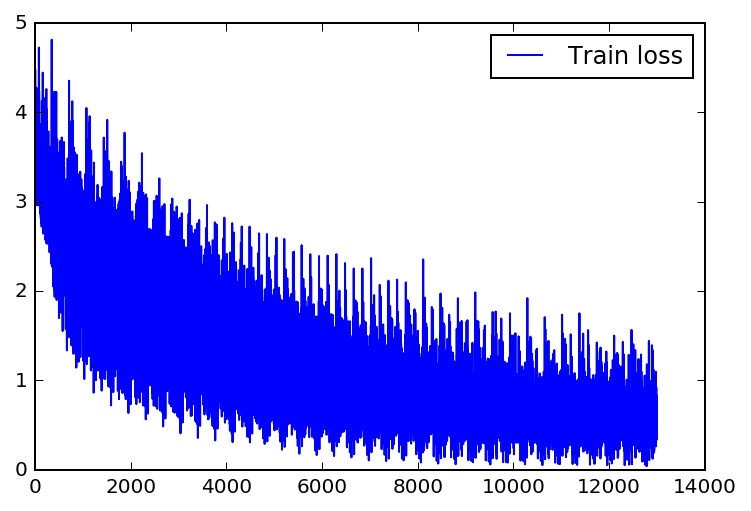

In [18]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.legend()
plt.show()